In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def shuffle_examples(X,y):
  p = np.random.permutation(len(X))
  return X[p],y[p]

def split_train_validation_test(X,y,p_t,p_tv):
  n = int(p_t*len(X))
  m = int(p_tv*len(X))
  return X[:n],y[:n],X[n:m],y[n:m],X[m:],y[m:]   

def scale(x):
  mu = np.mean(x,axis=0)
  st = np.std(x,axis=0)
  return (x-mu)/st,mu,st  

def sigmoid(x):
  return 1/(1+np.exp(-x))

def relu(x):
  return np.maximum(0,x)  

def sigmoid_p(x):
  return sigmoid(x)*(1-sigmoid(x))

def relu_p(x):
  return 1*(x >= 0)    

def error(y,y_hat):
  return -np.sum(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))/len(y)

def error_reg(y,y_hat,W,la):
  J_reg = -np.sum(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))/len(y)
  for l in range(1,len(W)):
    J_reg = J_reg + la*np.sum(W[l]**2)/len(y)
  return J_reg      

def accuracy_recall_precision(y_hat,y):
  y_hat_cat = 1*(y_hat > 0.5)
  correct_predictions = np.sum(y_hat_cat == y)
  predictions = len(y)
  true_positives = np.sum((y_hat_cat == 1) & (y == 1))
  positives = np.sum(y)
  predicted_positives = np.sum(y_hat_cat)
  accuracy = correct_predictions/predictions
  recall = true_positives/positives
  precision = true_positives/predicted_positives
  return accuracy, recall, precision  

def h(x,act):
  if act == 'sigmoid':
    return sigmoid(x)
  if act == 'relu':
    return relu(x)
  if act == 'identity':
    return x
  if act == 'tanh':
    return np.tanh(x)
  return 'Problem' 

def h_p(x,act):
  if act == 'sigmoid':
    return sigmoid_p(x)
  if act == 'relu':
    return relu_p(x)
  if act == 'identity':
    return 1
  if act == 'tanh':
    return 1/(np.cosh(x))**2
  return 'Problem'  

def As_Zs(X,W,b,act):
  A = [X]
  Z = [0]
  for l in range(1,len(b)):
    Z.append(np.matmul(A[-1],W[l])+b[l])
    A.append(h(Z[-1],act[l]))
  return A,Z 

def gradients(A,Z,act,W,y):
  y_hat = A[-1]
  l = len(W)-1
  DJ_DW = []
  DJ_Db = []
  DJ_DZ = (y_hat - y.reshape(-1,1))/len(y)
  while l > 1:
    DJ_DA = np.matmul(DJ_DZ,W[l].T)
    DJ_DW.insert(0,np.matmul(A[l-1].T,DJ_DZ)) 
    DJ_Db.insert(0,np.sum(DJ_DZ,axis=0))
    DJ_DZ = DJ_DA*h_p(Z[l-1],act[l-1])
    l = l-1
  DJ_DA = np.matmul(DJ_DZ,W[1].T)
  DJ_DW.insert(0,np.matmul(A[0].T,DJ_DZ)) 
  DJ_Db.insert(0,np.sum(DJ_DZ,axis=0)) 
  DJ_DW.insert(0,0) 
  DJ_Db.insert(0,0)  
  return DJ_DW,DJ_Db  

def update_parameters(W,b,DJ_DW,DJ_Db,c):
  for l in range(1,len(b)):
    W[l] = W[l] - c*DJ_DW[l]
    b[l] = b[l] - c*DJ_Db[l]
  return W, b  

def update_parameters_reg(W,b,DJ_DW,DJ_Db,c,m,la):
  for l in range(1,len(b)):
    W[l] = W[l] - c*DJ_DW[l] - 2*c*la*W[l]/m
    b[l] = b[l] - c*DJ_Db[l] 
  return W, b  

def initialize_W_and_b(n):
  W = [0]
  b = [0]
  for l in range(1,len(n)):
    W.append(np.random.randn(n[l-1],n[l])/np.sqrt(n[l-1]))
    b.append(np.zeros(n[l]))
  return W, b 

def steepest(n,act,X,y,epochs,c):
  W, b = initialize_W_and_b(n)
  J_list = []
  for i in range(epochs):
    A, Z = As_Zs(X,W,b,act)
    y_hat = A[-1]
    J_list.append(error(y,y_hat.reshape(-1)))
    DJ_DW, DJ_Db = gradients(A,Z,act,W,y)
    W, b = update_parameters(W,b,DJ_DW,DJ_Db,c)
  return W, b, J_list   

def steepest_reg(n,act,X,y,epochs,c,la):
  W, b = initialize_W_and_b(n)
  J_list = []
  for i in range(epochs):
    A, Z = As_Zs(X,W,b,act)
    y_hat = A[-1]
    J_list.append(error_reg(y,y_hat.reshape(-1),W,la))
    DJ_DW, DJ_Db = gradients(A,Z,act,W,y)
    W, b = update_parameters_reg(W,b,DJ_DW,DJ_Db,c,len(y),la)
  return W, b, J_list           

def predict(X,W,b,act):
  A,Z = As_Zs(X,W,b,act)
  return A[-1].reshape(-1)

def scale_predict(X,X_train_mean,X_train_std,W,b,act):
  return predict((X-X_train_mean)/X_train_std,W,b,act)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
X_org = np.load('/content/drive/MyDrive/Data/images.npy')
y = np.load('/content/drive/MyDrive/Data/labels.npy')

In [47]:
X_org, y = shuffle_examples(X_org,y)
X = X_org.reshape(X.shape[0],-1) 

In [58]:
p_t = 0.8
p_tv = 1
X_train, y_train, X_val, y_val, X_test, y_test = split_train_validation_test(X,y,p_t,p_tv)
X_train_scaled, X_train_mean, X_train_std = scale(X_train)

In [59]:
n = [X.shape[1], 1]
act = [None,'sigmoid']
c = 0.01
epochs = 200

In [60]:
W, b, J_list = steepest(n,act,X_train_scaled,y_train,epochs,c)

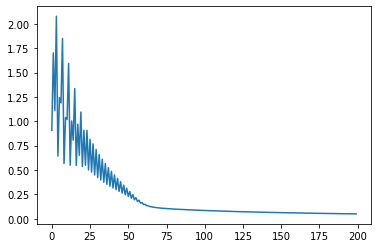

In [61]:
plt.plot(J_list)

In [63]:
y_hat = scale_predict(X_train,X_train_mean,X_train_std,W,b,act)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat,y_train))
print('c e error =',error(y_train,y_hat))

accuracy, recall, precision = (0.9951690821256038, 1.0, 0.9878048780487805)
c e error = 0.04901783896600716


In [64]:
y_hat = scale_predict(X_val,X_train_mean,X_train_std,W,b,act)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat,y_val))
print('c e error =',error(y_val,y_hat))

accuracy, recall, precision = (0.6730769230769231, 0.75, 0.6206896551724138)
c e error = 1.278840076015088


In [74]:
n = [X.shape[1], 4, 1]
act = [None,'relu', 'sigmoid']
c = 0.01
epochs = 1600

In [75]:
W, b, J_list = steepest(n,act,X_train_scaled,y_train,epochs,c)

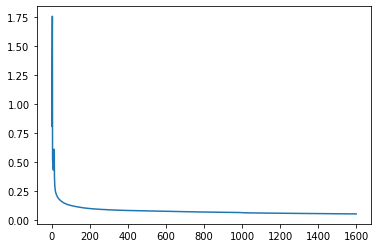

In [76]:
plt.plot(J_list)

In [77]:
y_hat = scale_predict(X_train,X_train_mean,X_train_std,W,b,act)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat,y_train))
print('c e error =',error(y_train,y_hat))

accuracy, recall, precision = (0.9951690821256038, 1.0, 0.9878048780487805)
c e error = 0.0531041910954985


In [78]:
y_hat = scale_predict(X_val,X_train_mean,X_train_std,W,b,act)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat,y_val))
print('c e error =',error(y_val,y_hat))

accuracy, recall, precision = (0.6730769230769231, 0.625, 0.6521739130434783)
c e error = 1.9451891226580704


In [80]:
n = [X.shape[1], 20, 4, 1]
act = [None,'relu', 'relu', 'sigmoid']
c = 0.01
epochs = 6400

In [81]:
W, b, J_list = steepest(n,act,X_train_scaled,y_train,epochs,c)

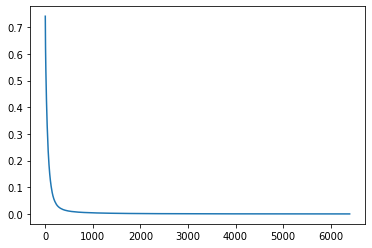

In [82]:
plt.plot(J_list)

In [83]:
y_hat = scale_predict(X_train,X_train_mean,X_train_std,W,b,act)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat,y_train))
print('c e error =',error(y_train,y_hat))

accuracy, recall, precision = (1.0, 1.0, 1.0)
c e error = 0.0002881990960805723


In [84]:
y_hat = scale_predict(X_val,X_train_mean,X_train_std,W,b,act)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat,y_val))
print('c e error =',error(y_val,y_hat))

accuracy, recall, precision = (0.7115384615384616, 0.6666666666666666, 0.6956521739130435)
c e error = 2.15239651940355


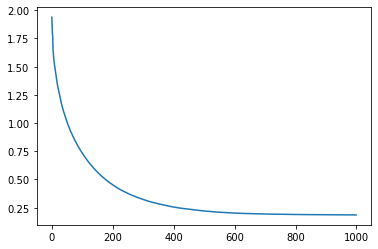

In [106]:
la = 10
n = [X.shape[1], 20, 4, 1]
act = [None,'relu', 'relu', 'sigmoid']
c = 0.04
epochs = 1000
W, b, J_list = steepest_reg(n,act,X_train_scaled,y_train,epochs,c,la)
plt.plot(J_list)

In [107]:
y_hat = scale_predict(X_train,X_train_mean,X_train_std,W,b,act)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat,y_train))
print('c e error =',error(y_train,y_hat))

accuracy, recall, precision = (1.0, 1.0, 1.0)
c e error = 0.03445543927388826


In [108]:
y_hat = scale_predict(X_val,X_train_mean,X_train_std,W,b,act)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat,y_val))
print('c e error =',error(y_val,y_hat))

accuracy, recall, precision = (0.75, 0.6666666666666666, 0.7619047619047619)
c e error = 0.9845064124874182


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply


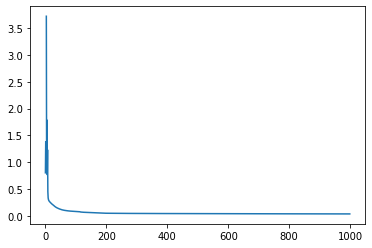

In [121]:
la = 1
n = [X.shape[1], 4, 1]
act = [None, 'relu', 'sigmoid']
c = 0.04
epochs = 1000
W, b, J_list = steepest_reg(n,act,X_train_scaled,y_train,epochs,c,la)
plt.plot(J_list)

In [122]:
y_hat = scale_predict(X_train,X_train_mean,X_train_std,W,b,act)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat,y_train))
print('c e error =',error(y_train,y_hat))

accuracy, recall, precision = (0.9951690821256038, 1.0, 0.9878048780487805)
c e error = 0.015653703279953024


In [123]:
y_hat = scale_predict(X_val,X_train_mean,X_train_std,W,b,act)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat,y_val))
print('c e error =',error(y_val,y_hat))

accuracy, recall, precision = (0.7115384615384616, 0.7083333333333334, 0.68)
c e error = 1.8289517849498713


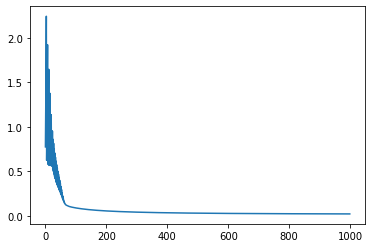

In [132]:
la = 1
n = [X.shape[1], 1]
act = [None, 'sigmoid']
c = 0.01
epochs = 1000
W, b, J_list = steepest_reg(n,act,X_train_scaled,y_train,epochs,c,la)
plt.plot(J_list)

In [136]:
y_hat_train = scale_predict(X_train,X_train_mean,X_train_std,W,b,act)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat_train,y_train))
print('c e error =',error(y_train,y_hat_train))

accuracy, recall, precision = (1.0, 1.0, 1.0)
c e error = 0.012407571259117274


In [138]:
y_hat_val = scale_predict(X_val,X_train_mean,X_train_std,W,b,act)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat_val,y_val))
print('c e error =',error(y_val,y_hat_val))

accuracy, recall, precision = (0.7115384615384616, 0.75, 0.6666666666666666)
c e error = 1.635675089577934


[0.03393206]
0


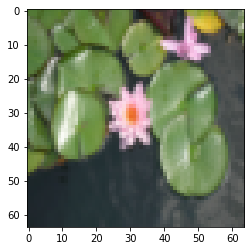

In [157]:
i = 233
plt.imshow(X_org[i])
print(scale_predict(X[i],X_train_mean,X_train_std,W,b,act))
print(y[i])

In [145]:
print(len(y))

259
